### Best Seller Prediction  

In this notebook, we develop a **Logistic Regression** model to predict whether a book is a *best seller* based on its **description** and **rating**. The goal is to classify books as *best sellers* (`1`) or *non-best sellers* (`0`) using natural language processing (NLP) and statistical modeling techniques.  

The dataset used for this task was obtained from Kaggle:  
📘 [**Goodreads Book Datasets With User Rating 2M**](https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m)

For this experiment, we specifically utilize the **`book4000k-5000k.csv`** file from the dataset, which contains detailed book descriptions and corresponding user ratings.  

In the next section, we will install and import all the required Python packages necessary for data preprocessing, feature extraction, and model training.  


In [1]:
!pip install helperfns pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 17.2 MB/s eta 0:00:00


In the following code cell, we will import all the essential Python libraries required for this notebook. These libraries will be used for data preprocessing, visualization, feature extraction, and building the Logistic Regression model.


In [37]:
import random
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark
import warnings
import sklearn

from pigmenta import PALETTES
from helperfns.visualization import plot_wordcloud, plot_classification_report, plot_complicated_confusion_matrix
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, regexp_replace, length, avg, explode, col, size
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from pyspark.ml.feature import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from joblib import dump


warnings.filterwarnings('ignore')

print("Pandas: ", pd.__version__)
print("Spark: ", pyspark.__version__)
print("Seaborn: ", sns.__version__)
print("Sklearn: ", sklearn.__version__)
print("Numpy: ", np.__version__)

Pandas:  2.2.2
Spark:  3.5.1
Seaborn:  0.13.2
Sklearn:  1.6.1
Numpy:  2.0.2


### Seed  

In the following code cell, we will set a fixed random seed to ensure **reproducibility** of all random operations in this notebook. This guarantees that results remain consistent across multiple runs.


In [3]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)

In the following code cell, we will load the dataset by reading the CSV file named **`book4000k-5000k.csv`** into a **pandas DataFrame**. This will allow us to explore and analyze the data efficiently in subsequent steps.


In [6]:
dataframe = pd.read_csv('book4000k-5000k.csv')
dataframe.head(2)

,Id,Name,Authors,ISBN,Rating,PublishYear,PublishMonth,PublishDay,Publisher,RatingDist5,RatingDist4,RatingDist3,RatingDist2,RatingDist1,RatingDistTotal,CountsOfReview,Language,PagesNumber,Description
0,4000000,Top Management,Bernard Taylor,0582446058,0.00,1973,1,1,Longman Publishing Group,5:0,4:0,3:0,2:0,1:0,total:0,0,NaN,448,NaN
1,4000001,"Celtic Warfare, 1595 1763",James Michael Hill,0859761517,3.67,1986,1,1,J. Donald,5:1,4:1,3:0,2:1,1:0,total:3,0,NaN,203,NaN


In the following code cell, we will select two relevant columns from the dataset - **`Description`** and **`Rating`** - which will be used for analysis and model training. All other columns will be excluded as they are not required for this task.


In [7]:
dataframe = dataframe[["Description", "Rating"]]
dataframe.head(2)

,Description,Rating
0,NaN,0.00
1,NaN,3.67


In the following code cell, we will examine the size of the dataset before removing any **null** values. This will help us understand the initial number of records and assess the extent of missing data.


In [8]:
print(f"The original dataset size is: {len(dataframe):,}")

The original dataset size is: 280,256


In the following code cell, we will remove all rows containing **NaN** or missing values using the `dropna()` function to ensure data quality and prevent errors during model training.


In [9]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()
dataframe.head(2)

,Description,Rating
0,Playwright Power is a concise handbook on how ...,0.0
1,Gives an account of the various aspects of the...,0.0


In the following code cell, we will check the size of the dataset after dropping all **null** values. This allows us to verify how many records remain for analysis and model training.


In [10]:
print(f"The cleaned dataset size is: {len(dataframe):,}")

The cleaned dataset size is: 184,554


In the following code cell, we will determine the **maximum** and **minimum** ratings of the books in the dataset. This information will help us set an appropriate **threshold** for identifying best sellers.


In [11]:
print(f"The minimum rating is: {dataframe.Rating.min()}")
print(f"The maximum rating is: {dataframe.Rating.max()}")

The minimum rating is: 0.0
The maximum rating is: 5.0


We will create a new **label** to indicate whether a book is a *best seller* or not based on its rating. Any book with a **rating greater than 2.5** will be classified as a *best seller* (`1`), while the remaining books will be classified as *non-best sellers* (`0`).


In [12]:
dataframe['BestSeller'] = dataframe['Rating'].apply(lambda x: 1 if x > 2.5 else 0)
dataframe.head(2)

,Description,Rating,BestSeller
0,Playwright Power is a concise handbook on how ...,0.0,0
1,Gives an account of the various aspects of the...,0.0,0


In the following code cell, we will save the processed DataFrame into a **CSV file**. This allows us to store the cleaned and labeled dataset for future use or analysis.


In [13]:
dataframe.to_csv('labeled_data.csv', index=False)

### 🔍 Data Analysis Using Spark  

In this section, we will perform **data analysis using Apache Spark**. To begin, we will create a **Spark session**, which allows us to handle large datasets efficiently and perform distributed computations for faster analysis.


In [14]:
spark = SparkSession.builder.appName("BestSellerSession").getOrCreate()
spark

### 🔍 Data Analysis Using Spark  

In this section, we will perform **data analysis using Apache Spark**. To begin, we will create a **Spark session**, which allows us to handle large datasets efficiently and perform distributed computations for faster analysis.


In [15]:
df = spark.read.csv("labeled_data.csv", header=True, inferSchema=True)
df.show(2)

+--------------------+------+----------+
|         Description|Rating|BestSeller|
+--------------------+------+----------+
|Playwright Power ...|   0.0|         0|
|Gives an account ...|   0.0|         0|
+--------------------+------+----------+
only showing top 2 rows



### Descriptive Statistics  

In this section, we will examine the **summary statistics** of the numeric columns in the dataset. This provides an overview of key metrics such as mean, minimum, maximum, and standard deviation, which help us understand the data distribution.


In [16]:
df.describe(["Rating"]).show()

+-------+--------------------+
|summary|              Rating|
+-------+--------------------+
|  count|              185593|
|   mean|  2.4541829087311373|
| stddev|   26.30939304183449|
|    min|                    |
|    max|™""</i> Terry Jo ...|
+-------+--------------------+



### 🧮 3. Textual Feature Insights (Description)  

Since the **`Description`** column contains text data, we will perform a textual analysis to extract meaningful features.  

#### a. Description Length  

We will create a new column representing the **length of each book description**. This serves as a proxy for verbosity and can provide insights into whether description length correlates with best seller status.


In [17]:
df = df.withColumn("desc_length", length(col("Description")))
df.select("desc_length").describe().show()

+-------+------------------+
|summary|       desc_length|
+-------+------------------+
|  count|            188694|
|   mean| 630.1016672496211|
| stddev|504.58481145117065|
|    min|                 1|
|    max|             31515|
+-------+------------------+



### Average Description Length by Class

In [18]:
df.groupBy("BestSeller").avg("desc_length").show(5)

+--------------------+----------------+
|          BestSeller|avg(desc_length)|
+--------------------+----------------+
|   Vlad l'impalatore|           433.0|
| they have grown ...|           247.0|
|    and work.<br />"|           773.0|
| Air and Fire"" r...|           150.0|
| the adults aroun...|           249.0|
+--------------------+----------------+
only showing top 5 rows



### b. Most Common Words  

In this step, we will **tokenize** the book descriptions and extract the most frequent words. This helps us identify the key terms and phrases that appear most often in the dataset, which may be useful for feature engineering and model building.


In [19]:
tokenizer = Tokenizer(inputCol="Description", outputCol="words")
words_df = tokenizer.transform(df)
words_exploded = words_df.select(explode(col("words")).alias("word"))
words_exploded.groupBy("word").count().orderBy(col("count").desc()).show(5)

+----+-------+
|word|  count|
+----+-------+
| the|1084627|
| and| 773714|
|  of| 761499|
|  in| 390561|
|  to| 379644|
+----+-------+
only showing top 5 rows



In the following code cell, we will visualize the **distribution of the target labels** using a **bar chart**. This will help us understand the balance between best sellers and non-best sellers in the dataset.


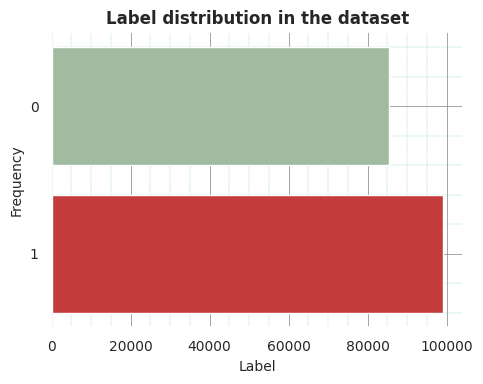

In [20]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(5, 4))
sns.countplot(data=dataframe, y="BestSeller", palette=PALETTES.halloween,
              legend=False,  fill=True)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(f"Label distribution in the dataset", fontsize=12, weight="bold")
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

The dataset is **imbalanced** in terms of target labels, with one class significantly outnumbering the other. To improve model performance, we will apply techniques to **balance the dataset**, ensuring that both best sellers and non-best sellers are adequately represented.


In [21]:
new_dataframe = dataframe.copy()

min_class_count = new_dataframe['BestSeller'].value_counts().min()
downsampled_list = []
for seller in new_dataframe['BestSeller'].unique():
    class_df = new_dataframe[new_dataframe['BestSeller'] == seller]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

In the following code cell, we will visualize the **distribution of target labels after balancing** the dataset. This helps confirm that the classes are now evenly represented for improved model training.


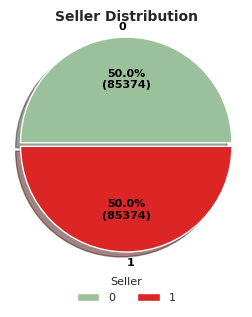

In [22]:
samples = dict(balanced_df.BestSeller.value_counts())

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.figure(figsize=(3, 3))
plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, sum(samples.values())),
    textprops={'color': 'black', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=PALETTES.halloween,
    explode=[.01 for _ in range(len(samples))]
)
plt.axis('equal')
plt.title("Seller Distribution", fontsize=10, weight="bold")
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Seller", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

In [23]:
print(f"The size of the balanced dataset is: {len(balanced_df)}")

The size of the balanced dataset is: 170748


In the following code cell, we will **split the dataset into two subsets**: a **training set** for model training and a **test set** for evaluating model performance.


In [24]:
train, test = train_test_split(balanced_df, test_size=0.2, random_state=SEED)

In the following code cell, we will examine the **distribution of each label** in the dataset. This allows us to verify the balance between best sellers and non-best sellers before training the model.


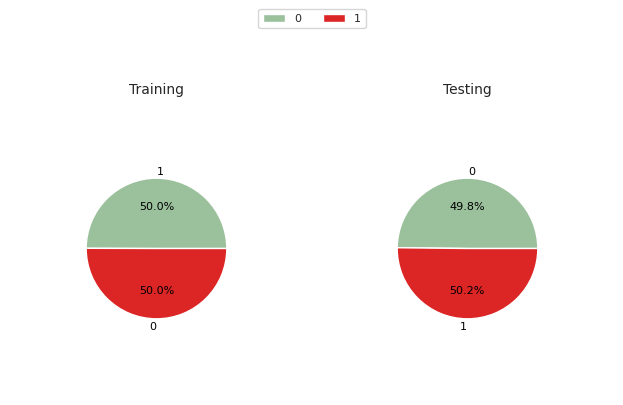

In [26]:

train_dist_label	= {i:0 for i in train.BestSeller.unique()}
for val in train.BestSeller:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test.BestSeller.unique()}
for val in test.BestSeller:
  test_dist_label[val] += 1

fig, axes = plt.subplots(1, 2)

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=.6,
            colors= PALETTES.halloween
            )
axes[0].set_title("Training", fontsize=10)

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=.6,
            colors= PALETTES.halloween
            )
axes[1].set_title("Testing", fontsize=10)


fig.legend(train.BestSeller.value_counts().index, loc="upper center", bbox_to_anchor=(0.5, 1.01), ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

In the following code cell, we will **extract the features and labels** from the dataset. Additionally, we will **clean the book descriptions** by removing unwanted characters and formatting, preparing the text data for model training.


In [27]:
train_texts = train.Description.values
train_labels = train.BestSeller.values

test_texts = test.Description.values
test_labels = test.BestSeller.values

MENTION_HASHTAG_RE = re.compile(r"(@|#)([A-Za-z0-9]+)")
EMAIL_RE = re.compile(r"([A-Za-z0-9]+[._-])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Za-z]{2,})+")
URL_RE = re.compile(r"https?\S+", re.MULTILINE)
DIGIT_RE = re.compile(r"\d")
PUNCT_RE = re.compile(r"[^\w\s\']")
SPACE_RE = re.compile(r"\s+")

def clean_sentence(sent: str, lower: bool = True) -> str:
    if lower:
        sent = sent.lower()
    sent = MENTION_HASHTAG_RE.sub(" ", sent)
    sent = EMAIL_RE.sub(" ", sent)
    sent = URL_RE.sub(" ", sent)
    sent = DIGIT_RE.sub(" ", sent)
    sent = PUNCT_RE.sub(" ", sent)
    sent = SPACE_RE.sub(" ", sent).strip()
    return sent


train_text = [clean_sentence(i) for i in train_texts]
test_text = [clean_sentence(i) for i in test_texts]

In the following code cell, we will create **pipelines for the model** as a list, pairing **`LogisticRegression`** with different vectorizers — **`CountVectorizer`**, **`HashingVectorizer`**, and **`TfidfVectorizer`**. This will allow us to **compare their performance** and determine the most effective feature representation for predicting best sellers.


In [28]:
scores_metrics = []

vectorizers = [
    (
        "CountVectorizer",
        CountVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 3),
            max_features=60000,
            binary=True,
            min_df=2,
            max_df=0.85,
            strip_accents='unicode',
            analyzer='word'
        )
    ),
    (
        "TfidfVectorizer",
        TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 3),
            max_features=60000,
            sublinear_tf=True,
            min_df=2,
            max_df=0.85,
            smooth_idf=True,
            norm='l2',
            use_idf=True,
            strip_accents='unicode'
        )
    ),
    (
        "HashingVectorizer",
        HashingVectorizer(
            n_features=2**18,
            alternate_sign=False,
            ngram_range=(1, 3),
            lowercase=True,
            norm='l2',
            stop_words='english',
            analyzer='word'
        )
    )
]


for vec_name, vect in vectorizers:
  lgr = LogisticRegression(
        solver='lbfgs',
        C=2.0,
        max_iter=2000,
        class_weight='balanced'
  )
  pipe = Pipeline([
      ("vect", vect),
      ("clf", lgr)
  ])
  pipe.fit(train_text, train_labels)
  score = pipe.score(test_text, test_labels)
  scores_metrics.append({"vectorizer": vec_name,  "score": score})
  print(f"{vec_name}: {score:.4f}")
print()

scores_df = pd.DataFrame(scores_metrics)
scores_df.head()


CountVectorizer: 0.6642
TfidfVectorizer: 0.7102
HashingVectorizer: 0.7091



,vectorizer,score
0,CountVectorizer,0.664187
1,TfidfVectorizer,0.710220
2,HashingVectorizer,0.709136


In the following code cell, we will **visualize the performance of each vectorizer** by plotting their corresponding **accuracy scores**. This helps us compare which feature representation works best for predicting best sellers.


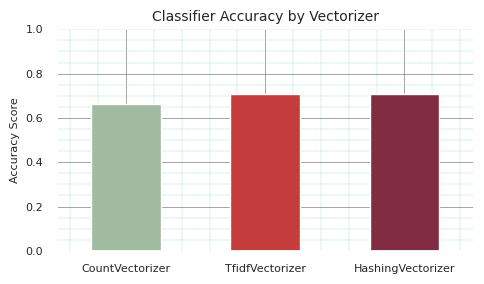

In [31]:
plt.figure(figsize=(5, 3))
sns.barplot(data=scores_df, x="vectorizer", y="score", palette=PALETTES.halloween, width= .5)

plt.title("Classifier Accuracy by Vectorizer", fontsize=10)
plt.ylabel("Accuracy Score", fontdict={'fontsize': 8})
plt.xlabel("", fontdict={'fontsize': 8})
plt.ylim(0, 1.0)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.tight_layout()
plt.show()

In the next code cell, we will select the **vectorizer and Logistic Regression combination** that yields the **highest accuracy**. This combination will be used as the **best model**, which we will then evaluate on the test set to assess its performance.


In [32]:
pipe = Pipeline([
    ("vect",  TfidfVectorizer(
            lowercase=True,
            stop_words='english',
            ngram_range=(1, 3),
            max_features=60000,
            sublinear_tf=True,
            min_df=2,
            max_df=0.85,
            smooth_idf=True,
            norm='l2',
            use_idf=True,
            strip_accents='unicode'
        )),
    ("clf", LogisticRegression(
        solver='lbfgs',
        C=2.0,
        max_iter=2000,
        class_weight='balanced'
  ))
])
pipe.fit(train_texts, train_labels)


In the following code cell, we will perform a **grid search** to find the **optimal hyperparameters** for both the `LogisticRegression` model and the `TfidfVectorizer`. This will help improve the performance of the classification task by identifying the best parameter settings.


In [47]:
pipe = Pipeline([
    ("vect",  TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        strip_accents='unicode'
    )),
    ("clf", LogisticRegression(
        solver='lbfgs',
        max_iter=2000
    ))
])

param_grid = {
    "vect__ngram_range": [(1,2), (1,3)],
    "clf__class_weight": ["balanced", None]
}


In the following code cell, we will use **GridSearchCV** to find the **best pipeline** - the combination of `TfidfVectorizer` and `LogisticRegression` that achieves the **highest performance** on the training data. This allows us to automatically tune hyperparameters and select the optimal model for predicting best sellers.


In [50]:
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=2,
    verbose=3,
    n_jobs=-1
)

grid_search.fit(train_text, train_labels)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english',
                                                        strip_accents='unicode')),
                                       ('clf',
                                        LogisticRegression(max_iter=2000))]),
             n_jobs=-1,
             param_grid={'clf__class_weight': ['balanced', None],
                         'vect__ngram_range': [(1, 2), (1, 3)]},
             scoring='f1', verbose=3)

In the following code cell, we will examine the **performance metrics** of the best model found by `GridSearchCV`. This includes the best hyperparameters and the corresponding evaluation scores on the training data.


In [51]:
print("Best parameters found:")
print(grid_search.best_params_)
print("\nBest cross-validation F1-score: {:.4f}".format(grid_search.best_score_))

best_model = grid_search.best_estimator_
y_preds = best_model.predict(test_texts)

Best parameters found:
{'clf__class_weight': 'balanced', 'vect__ngram_range': (1, 2)}

Best cross-validation F1-score: 0.7212


In the following code cell, we will create a **confusion matrix plot** for the best pipeline, using the **testing data**. This visualization helps us understand how well the model distinguishes between best sellers and non-best sellers.


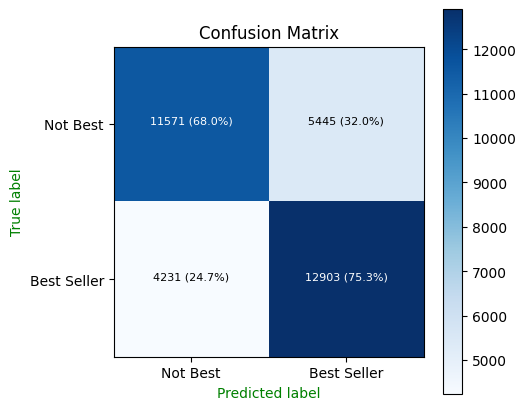

In [52]:
labels = ["Not Best", "Best Seller"]
plt.style.use('default')
plot_complicated_confusion_matrix(test_labels, y_preds,
  labels, fontsize=8, figsize=(5, 5)
)

In the following code cell, we will generate a **classification report** for the best pipeline using the **testing data**. This report provides detailed metrics such as precision, recall, F1-score, and support for each class, helping us evaluate the model's performance comprehensively.


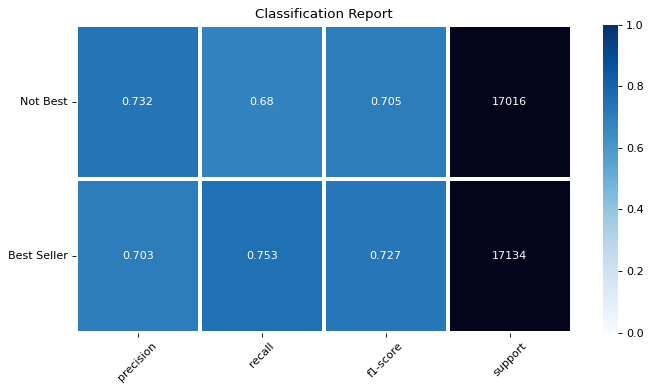

In [53]:
fig, ax = plot_classification_report(
    test_labels, y_preds,
    title='Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels
)

### Model Inference  

In this section of the notebook, we will use the **best pipeline** to make predictions based on **user input**. This allows us to classify new book descriptions as *best sellers* or *non-best sellers* in real time.


In [56]:
def predict_best_seller(desc, pipeline):
  desc = clean_sentence(desc)
  prediction = pipeline.predict([desc])
  return { "prediction": int(prediction[0]),
          "best_seller": "Yes" if prediction == 1 else "No"}

In the following code cell, we will use the model to **predict whether a book is a "best seller"** based on its **description** provided by the user.


In [57]:
desc = "Playwright Power is a concise handbook on how to write a play. Written by an award-winning playwright, this book is built on proven basics. It provides important information for the beginning playwright as well as solid reinforcement for those already established. Beginning with the definition of a play, this book goes on to explain the components of the script, the playwright's best environment and some questions the new playwright should think about before beginning. This book guides the playwright through the plot, building characters, the dialogue, and how to get the play produced."

predict_best_seller(
    desc, best_model
)

{'prediction': 1, 'best_seller': 'Yes'}

In the following code cell, we will use the model to **predict whether a book is "not a best seller"** based on its **description** provided by the user.


In [65]:
desc = "This guide explains key concepts in applying valuation multiples, including invested capital versus equity (and related pricing multiples), and how each of the databases handles liabilities. Databases covered in the Guide include: Pratt's Stats Private Trans-action Database, BIZCOMPS, FactSet Mergerstat Deal Report, and DoneDeals. Other market indications of value, such as Rules of Thumb and prior transactions are also included. A valuable resource for business analysts, business brokers, bankers, accountants, lawyers, judges, and others who need to understand the valuable data offered by the transaction databases."
predict_best_seller(
    desc, best_model
)

{'prediction': 0, 'best_seller': 'No'}

### Saving Objects  

In the following code cell, we will **save all the objects** required for model inference, including the trained pipeline, vectorizer, and any other components needed to make predictions on new data.


In [59]:
dump({
    "model": best_model,
}, "best_seller_bundle.joblib")
print("Done!")

Done!
